In [71]:
import numpy as np 
import pandas as pd
import seaborn as sns

import datetime
import sys
import os 

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats  
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

sys.path.append('..')
from src import config

if sys.platform == 'linux':
    path = config.LINUX_PATH
else:
    path = config.OS_PATH
os.chdir(path)

data_path = config.STRAVA_TRAIN_PATH
data = pd.read_csv(data_path, index_col=0)
print(data.columns.tolist())
data.head()

['name', 'distance', 'moving_time', 'total_elevation_gain', 'workout_type', 'timezone', 'achievement_count', 'kudos_count', 'athlete_count', 'photo_count', 'manual', 'max_speed', 'average_heartrate', 'max_heartrate', 'pr_count', 'total_photo_count', 'suffer_score', 'GMT_date', 'GMT_time', 'local_date', 'local_time', 'datetime', 'year', 'weekofyear', 'month', 'dayofweek', 'weekend', 'hour', 'is_uk_awake', 'run_area', 'latlng_cluster', 'city', 'average_speed_mpk']


,name,distance,moving_time,total_elevation_gain,workout_type,timezone,achievement_count,kudos_count,athlete_count,photo_count,...,weekofyear,month,dayofweek,weekend,hour,is_uk_awake,run_area,latlng_cluster,city,average_speed_mpk
257,All in,11.1764,50.350000,28.0,0.0,America/Los_Angeles,0.0,55.0,1.0,0.0,...,4,1,6,1,10,1,4.334562,1,North Las Vegas,4.504324
258,Vegas baby,13.1180,61.066667,9.0,0.0,America/Boise,1.0,46.0,1.0,0.0,...,4,1,5,1,9,1,75.277616,1,Boise,4.655307
259,WD,3.1968,16.016667,22.0,0.0,America/Boise,0.0,9.0,1.0,0.0,...,4,1,4,0,15,1,0.082079,1,Boise,5.009318
260,Pre meet,7.1960,28.383333,3.0,3.0,America/Boise,0.0,33.0,1.0,0.0,...,4,1,4,0,14,1,2.207397,1,Boise,3.944615
261,WU,4.8448,22.183333,44.0,0.0,America/Boise,0.0,11.0,1.0,0.0,...,4,1,4,0,14,1,0.166980,1,Boise,4.578571


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 742 entries, 257 to 1048
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  742 non-null    object 
 1   distance              742 non-null    float64
 2   moving_time           742 non-null    float64
 3   total_elevation_gain  742 non-null    float64
 4   workout_type          712 non-null    float64
 5   timezone              742 non-null    object 
 6   achievement_count     742 non-null    float64
 7   kudos_count           742 non-null    float64
 8   athlete_count         742 non-null    float64
 9   photo_count           742 non-null    float64
 10  manual                742 non-null    bool   
 11  max_speed             742 non-null    float64
 12  average_heartrate     716 non-null    float64
 13  max_heartrate         716 non-null    float64
 14  pr_count              742 non-null    float64
 15  total_photo_count   

In [73]:
numeric_cols = [
                'distance', 'moving_time', 'total_elevation_gain', 'photo_count', 'max_speed',
                'average_heartrate', 'max_heartrate', 'pr_count', 'total_photo_count', 'suffer_score', 
                'run_area', 'average_speed_mpk', 'kudos_count'
                ]
cat_cols = [
            'workout_type', 'timezone', 'manual', 'year', 'weekofyear', 'month', 'dayofweek', 'weekend', 
            'hour', 'is_uk_awake', 'latlng_cluster', 'city'
            ]

Numeric and categorical columns 

In [74]:
# plot helper func
def plot_dist(data, col_name):
    print(data[col_name].describe())
    plt.figure(figsize=(9, 8))
    sns.displot(data[col_name], color='g', bins=100);

# Target variable

count    742.000000
mean      38.432615
std       25.039190
min        1.000000
25%       14.000000
50%       37.000000
75%       53.000000
max      171.000000
Name: kudos_count, dtype: float64


<Figure size 648x576 with 0 Axes>

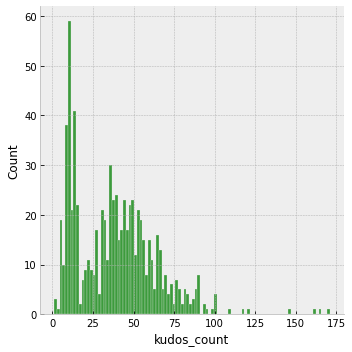

In [75]:
plot_dist(data, 'kudos_count')

With this information we can see that the kudos are skewed right (bimodal) and some outliers lies above ~100 (which we may want to consider removing before modeling). We would like to see more of a normal dist., so lets try using a BoxCox transform.

count    7.420000e+02
mean     1.922691e-16
std      1.000675e+00
min     -2.542068e+00
25%     -1.021551e+00
50%      1.548634e-01
75%      7.137420e-01
max      3.153583e+00
Name: target_boxcox, dtype: float64


<Figure size 648x576 with 0 Axes>

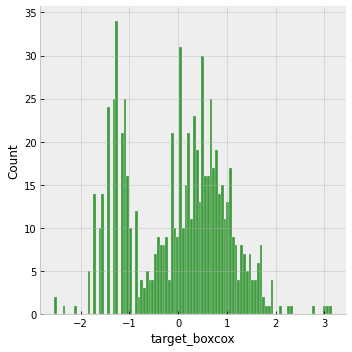

In [76]:
pt = PowerTransformer()
data.loc[:, 'target_boxcox'] = pt.fit_transform(data[['kudos_count']])
plot_dist(data, 'target_boxcox')

This looks more like a Gaussian curve. We need to sort outliers though. 

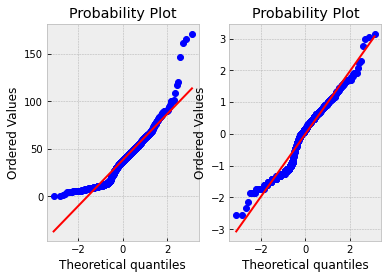

In [77]:
# pp-plots
plt.subplot(1, 2, 1)
res1 = stats.probplot(data['kudos_count'], plot=plt)
plt.subplot(1, 2, 2)
res = stats.probplot(data['target_boxcox'], plot=plt)
plt.show()

## Isolation Forest To Find Outliers

In [78]:
# training the model
outlier_model = IsolationForest(random_state=42)
cols = numeric_cols.copy()
data_train = data[cols].dropna()
outlier_model.fit(data_train)

# predictions
y_pred = outlier_model.predict(data_train)
from collections import Counter
Counter(y_pred)

Counter({1: 645, -1: 71})

In [79]:
data_train.loc[:, 'anomaly'] = outlier_model.predict(data_train)
data_train.head(20)

,distance,moving_time,total_elevation_gain,photo_count,max_speed,average_heartrate,max_heartrate,pr_count,total_photo_count,suffer_score,run_area,average_speed_mpk,kudos_count,anomaly
257,11.1764,50.350000,28.0,0.0,8.4,144.2,162.0,0.0,0.0,23.0,4.334562,4.504324,55.0,1
258,13.1180,61.066667,9.0,0.0,4.6,147.1,179.0,0.0,0.0,43.0,75.277616,4.655307,46.0,1
259,3.1968,16.016667,22.0,0.0,4.7,155.2,165.0,0.0,0.0,18.0,0.082079,5.009318,9.0,1
260,7.1960,28.383333,3.0,0.0,8.6,148.7,173.0,0.0,0.0,16.0,2.207397,3.944615,33.0,1
261,4.8448,22.183333,44.0,0.0,4.9,151.0,167.0,0.0,0.0,20.0,0.166980,4.578571,11.0,1
262,8.1354,36.100000,10.0,0.0,5.3,148.2,164.0,0.0,0.0,26.0,5.870196,4.437167,32.0,1
263,12.9277,59.283333,49.0,0.0,5.5,150.2,165.0,0.0,0.0,52.0,37.574116,4.586131,44.0,1
264,6.7834,30.283333,9.0,0.0,7.6,153.4,165.0,0.0,0.0,29.0,4.207750,4.464506,27.0,1
265,8.0925,36.616667,15.0,0.0,4.9,153.1,171.0,0.0,0.0,35.0,4.071707,4.525115,32.0,1
266,16.2753,76.333333,266.6,0.0,5.7,149.9,171.0,0.0,0.0,55.0,3.825407,4.689364,58.0,1


## IQR TO Find Outliers

In [85]:
outlier_model = LocalOutlierFactor(n_neighbors = 2, metric = "manhattan", contamination = 0.02)

cols = numeric_cols.copy()
data_train = data[cols].dropna()

y_pred = outlier_model.fit_predict(data_train)
print(Counter(y_pred))

Counter({1: 701, -1: 15})


In [86]:
outlier_index = np.where(y_pred == -1) # negative values are outliers and positives inliers
outlier_values = data_train.iloc[outlier_index] # filter outlier values
# print(outlier_values)

non_outlier_index = np.where(y_pred == 1)
data_outliers_removed = data_train.iloc[non_outlier_index]

count    701.000000
mean      38.456491
std       24.636556
min        1.000000
25%       14.000000
50%       38.000000
75%       54.000000
max      165.000000
Name: kudos_count, dtype: float64


<Figure size 648x576 with 0 Axes>

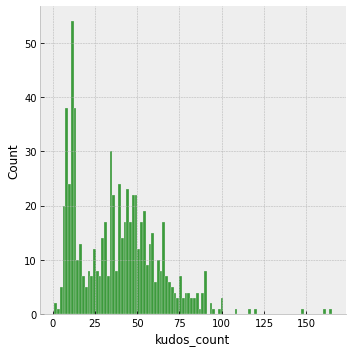

In [87]:
plot_dist(data_outliers_removed, 'kudos_count')

count    7.010000e+02
mean    -2.120471e-16
std      1.000714e+00
min     -2.530688e+00
25%     -1.033677e+00
50%      1.863274e-01
75%      7.444529e-01
max      3.116422e+00
Name: target_boxcox, dtype: float64


/home/jack/miniconda3/envs/pycaret/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<Figure size 648x576 with 0 Axes>

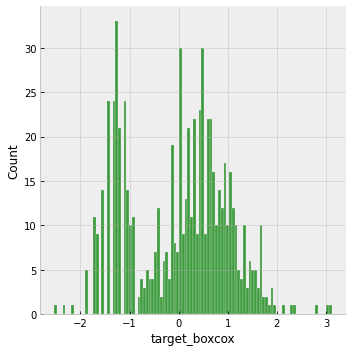

In [89]:
pt = PowerTransformer()
data_outliers_removed.loc[:, 'target_boxcox'] = pt.fit_transform(data_outliers_removed[['kudos_count']])
plot_dist(data_outliers_removed, 'target_boxcox')

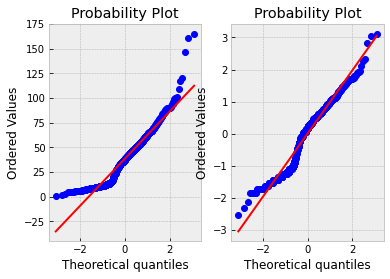

In [90]:
# pp-plots
plt.subplot(1, 2, 1)
res1 = stats.probplot(data_outliers_removed['kudos_count'], plot=plt)
plt.subplot(1, 2, 2)
res = stats.probplot(data_outliers_removed['target_boxcox'], plot=plt)
plt.show()

# Numerical data distribution

## Distributions

In [91]:
data_num = data[numeric_cols]
data_num.head()

,distance,moving_time,total_elevation_gain,photo_count,max_speed,average_heartrate,max_heartrate,pr_count,total_photo_count,suffer_score,run_area,average_speed_mpk,kudos_count
257,11.1764,50.350000,28.0,0.0,8.4,144.2,162.0,0.0,0.0,23.0,4.334562,4.504324,55.0
258,13.1180,61.066667,9.0,0.0,4.6,147.1,179.0,0.0,0.0,43.0,75.277616,4.655307,46.0
259,3.1968,16.016667,22.0,0.0,4.7,155.2,165.0,0.0,0.0,18.0,0.082079,5.009318,9.0
260,7.1960,28.383333,3.0,0.0,8.6,148.7,173.0,0.0,0.0,16.0,2.207397,3.944615,33.0
261,4.8448,22.183333,44.0,0.0,4.9,151.0,167.0,0.0,0.0,20.0,0.166980,4.578571,11.0


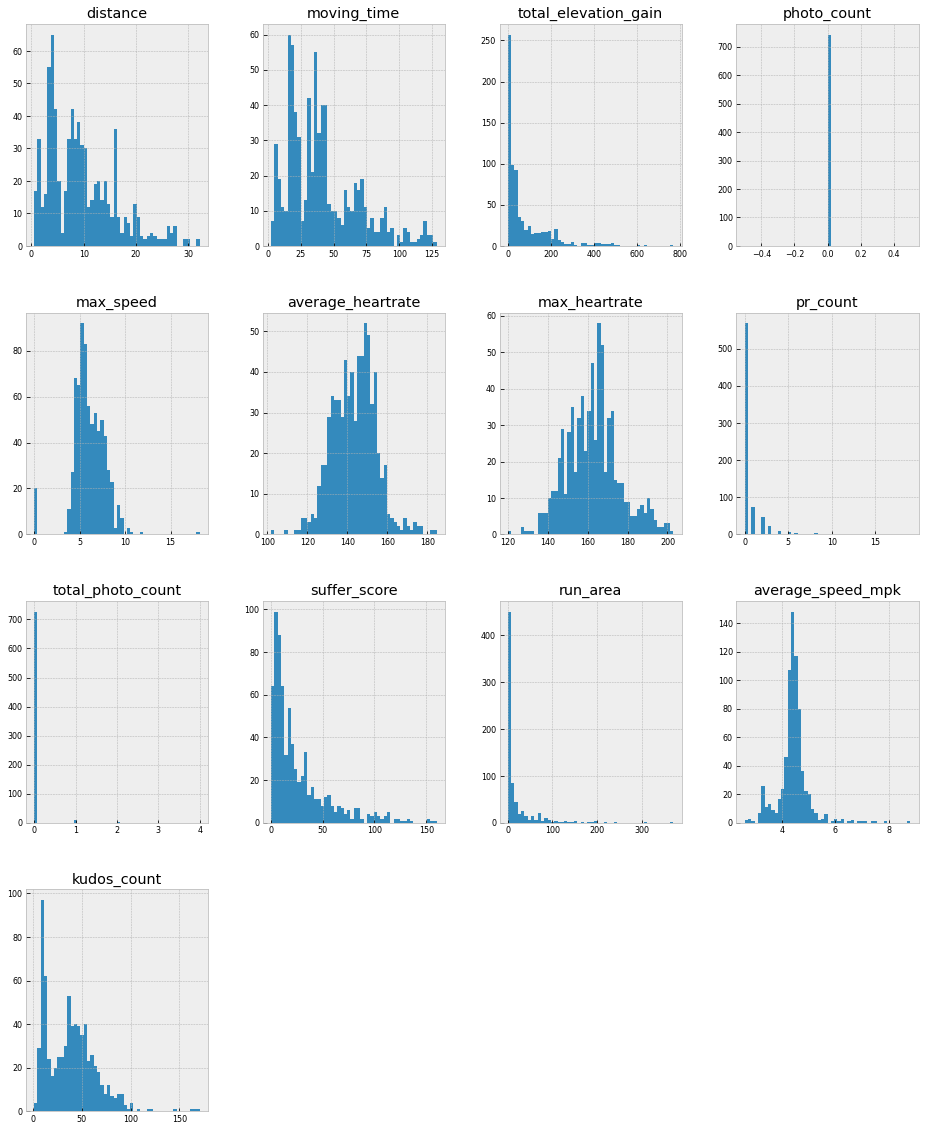

In [92]:
data_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Features such as `distance`, `moving_time`, `average_speed_mpk`, ... seems to share a similar distribution to the one we have with `kudos_count`. Lets see if we can find new clues later.
* photo count only has single value - needs to be dropped

In [93]:
col_to_drop = []
col_to_drop.append('photo_count')

## Correlation

Now we'll try to find which features are strongly correlated with `kudos_count`. We'll store them in a var called `golden_features_list`. We'll reuse our df_num dataset to do so.

In [94]:
data_num_corr = data_num.corr()['kudos_count'][:-1] # -1 because the latest row is kudos_count
golden_features_list = data_num_corr[abs(data_num_corr) > 0.5].sort_values(ascending=False)
print(f"There is {len(golden_features_list)} strongly correlated values with kudos count:\n{golden_features_list}")

There is 5 strongly correlated values with kudos count:
distance                0.759885
moving_time             0.711134
suffer_score            0.688198
max_heartrate           0.534818
total_elevation_gain    0.512659
Name: kudos_count, dtype: float64


Perfect, we now have a list of strongly correlated values but this list is incomplete as we know that correlation is affected by outliers. So we could proceed as follow:

* Plot the numerical features and see which ones have very few or explainable outliers
* Remove the outliers from these features and see which one can have a good correlation without their outliers

Also, correlation by itself does not always explain the relationship between data so ploting them could even lead us to new insights and in the same manner, check that our correlated values have a linear relationship to the `kudos_count`.

For example, relationships such as non-linear relationship cannot be guessed just by looking at the correlation value so lets take the features we excluded from our correlation table and plot them to see if they show some kind of pattern.

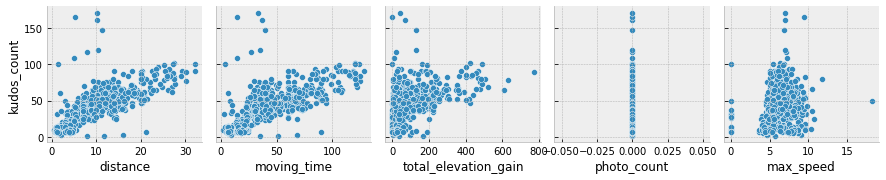

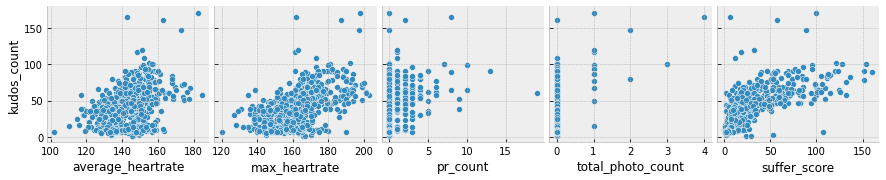

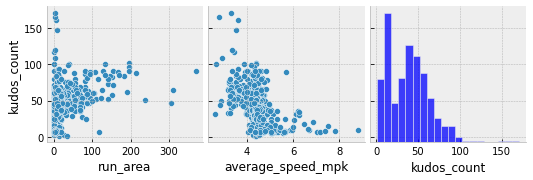

In [95]:
for i in range(0, len(data_num.columns), 5):
    sns.pairplot(data=data_num,
                x_vars=data_num.columns[i:i+5],
                y_vars=['kudos_count'])

We can clearly identify some relationships. Most of them seems to have a linear relationship with the kudos_count and if we look closely at the data we can see that a lot of data points are located on x = 0 which may indicate the run was not available to the public. 
* Maybe make total_photo_count binary feature and target encode